# MB_EP_PILO

In [160]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [161]:
import seaborn as sns
sns.set()

In [162]:
df = pd.read_excel("/Users/michaelzhang/Desktop/multiclass/pilo_ep_mb_features.xlsx")

In [163]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/multiclass/LASSO_reduced_features.xlsx")

In [164]:
reduced_features_list = reduced_features.loc[reduced_features['MB/EP/Pilo'].isnull() == False, ['MB/EP/Pilo']].values.tolist()

In [165]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [166]:
target = df["path"]

In [167]:
target.value_counts()

mb      278
pilo    160
ep       97
Name: path, dtype: int64

In [168]:
#Marking 0 as ep and 1 as pilo and 2 as mb
mapping_dict = {0: 'ep', 1: 'pilo', 2: 'mb'}
target = target.map(dict(ep = 0, pilo = 1, mb = 2))

In [169]:
features_after_lasso = df[reduced_features_list]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [171]:
y_train.value_counts()

2    218
1    115
0     68
Name: path, dtype: int64

In [172]:
y_test.value_counts()

2    60
1    45
0    29
Name: path, dtype: int64

# Principal Components Analysis - [Removed]

# Resampling to correct for imbalance

In [173]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['path'] == 0]
X_1 = X[X['path'] == 1]
X_2 = X[X['path'] == 2]

In [174]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_2), random_state = 42)
upsampled_1 = resample(X_1, replace = True, n_samples = len(X_2), random_state = 42)
upsampled = pd.concat([upsampled_0, upsampled_1, X_2])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [175]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [176]:
y_train.value_counts()

2    218
1    218
0    218
Name: path, dtype: int64

In [177]:
y_train_bin = label_binarize(y_train, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test, classes = [0, 1, 2])

# Standardizing Features

In [178]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [179]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [180]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [181]:
def specificity_score(y_pred, y_true):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [182]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [183]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [184]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.3f} - {:0.3}]".format(name, i,
        confidence_lower, confidence_upper))

# SVM

### Grid Search for Hyperparameters

In [185]:
svm_model = OneVsRestClassifier(svm.SVC())

In [186]:
grid_param = {'estimator__C': [0.1, 1, 10],
              'estimator__gamma': [1, 0.1, 0.01]
}


svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [187]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [188]:
print(svm_grid.best_params_)

{'estimator__C': 10, 'estimator__gamma': 0.1}


### Model Performance

In [189]:
svm_model = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [190]:
y_test_np = y_test.to_numpy()
TN = 0
TP = 0 ##
FN = 0 ##
FP = 0
tot_TN = TN
tot_TP = TP
tot_FN = FN
tot_FP = FP
spec_arr = []
ppv_arr = [] ##
npv_arr = [] ##

print("Specificities")
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TN += TN
    tot_FP += FP
    spec_arr.append(TN/(TN+FP))
    print(group, spec_arr[group])
    
print("Macro Avg : " + str(np.array(spec_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

print("PPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] == group and y_test_np[i] == group:
            TP += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TP += TP
    tot_FP += FP
    ppv_arr.append(TP/(TP+FP))
    print(group, ppv_arr[group])
    
print("Macro Avg : " + str(np.array(ppv_arr).mean()))
print("Micro Avg : " + str(tot_TP / (tot_TP + tot_FP)), '\n')

print("NPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] != group and y_test_np[i] == group:
            FN += 1
    tot_TN += TN
    tot_FN += FN
    npv_arr.append(TP/(TP+FP))
    print(group, npv_arr[group])
    
print("Macro Avg : " + str(np.array(npv_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN))) 

Specificities
0 0.8666666666666667
1 0.9123711340206185
2 0.8656716417910447
Macro Avg : 0.8815698141594432
Micro Avg : 0.8818342151675485 

PPV
0 0.21875
1 0.4854368932038835
2 0.5764705882352941
Macro Avg : 0.4268858271463925
Micro Avg : 0.400990099009901 

NPV
0 0.5764705882352941
1 0.5764705882352941
2 0.5764705882352941
Macro Avg : 0.5764705882352941
Micro Avg : 0.9576510446075663


In [191]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49        29
           1       0.92      0.80      0.86        45
           2       0.72      0.80      0.76        60

    accuracy                           0.73       134
   macro avg       0.71      0.69      0.70       134
weighted avg       0.74      0.73      0.73       134



In [192]:
n_classes = 3
svm_model_for_auc = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
y_score = svm_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = svm_model_for_auc.predict(X_test)

ep
Accuracy: 0.8059701492537313
pilo
Accuracy: 0.9402985074626866
mb
Accuracy: 0.753731343283582
Micro-Averaged AUC: 0.9100022276676321


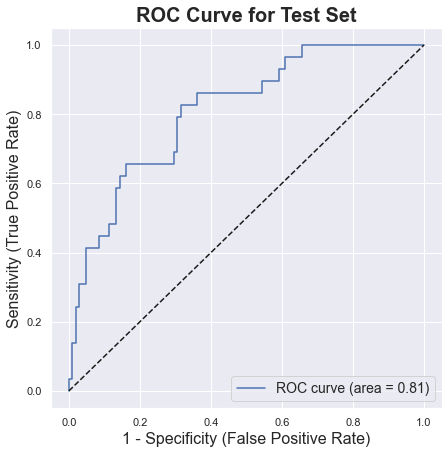

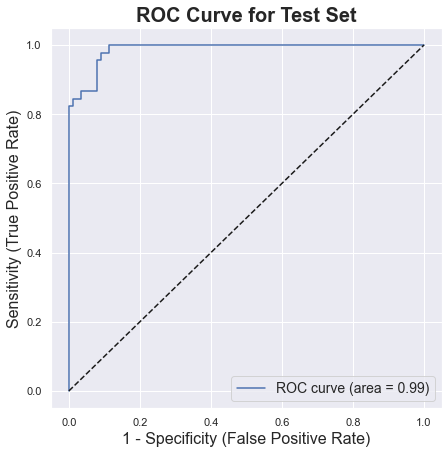

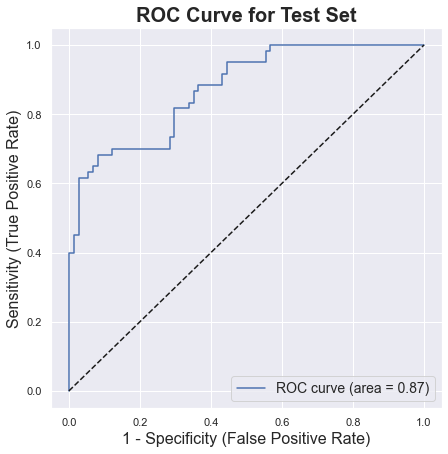

In [193]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))



# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()


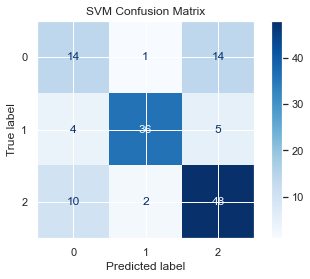

In [194]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

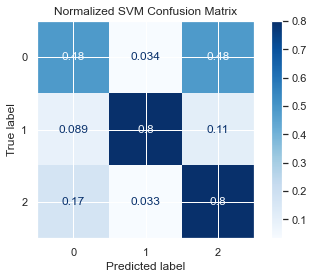

In [195]:
norm_matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [196]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##

    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [197]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.723 - 0.889]
95% Confidence interval for the AUC score for class 1: [0.973 - 0.997]
95% Confidence interval for the AUC score for class 2: [0.811 - 0.925]
95% Confidence interval for the Accuracy score for class 0: [0.739 - 0.866]
95% Confidence interval for the Accuracy score for class 1: [0.896 - 0.978]
95% Confidence interval for the Accuracy score for class 2: [0.679 - 0.821]
95% Confidence interval for the Specificity score for class 0: [0.859 - 0.962]
95% Confidence interval for the Specificity score for class 1: [1.000 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.600 - 0.803]
95% Confidence interval for the Precision score for class 0: [0.226 - 0.586]
95% Confidence interval for the Precision score for class 1: [0.698 - 0.93]
95% Confidence interval for the Precision score for class 2: [0.714 - 0.909]
95% Confidence interval for the Recall score for class 0: [0.350 - 0.778]
95% Confidence inter

# Logistic Regression

### Grid Search for Hyperparameters

In [198]:
lr_model = OneVsRestClassifier(LogisticRegression())
grid_param = {'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'estimator__C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [199]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10, 1, 0.1, 0.01, 0.001],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                'none']},
             scoring='accuracy')

In [200]:
print(lr_grid.best_params_)

{'estimator__C': 1, 'estimator__penalty': 'l2'}


### Model Performance

In [201]:
lr_model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1))
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [202]:
y_test_np = y_test.to_numpy()
TN = 0
TP = 0 ##
FN = 0 ##
FP = 0
tot_TN = TN
tot_FP = FP
spec_arr = []
ppv_arr = [] ##
npv_arr = [] ##

print("Specificities")
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TN += TN
    tot_FP += FP
    spec_arr.append(TN/(TN+FP))
    print(group, spec_arr[group])

print("Macro Avg : " + str(np.array(spec_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

print("PPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] == group and y_test_np[i] == group:
            TP += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TP += TP
    tot_FP += FP
    ppv_arr.append(TP/(TP+FP))
    print(group, ppv_arr[group])
    
print("Macro Avg : " + str(np.array(ppv_arr).mean()))
print("Micro Avg : " + str(tot_TP / (tot_TP + tot_FP)), '\n')

print("NPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] != group and y_test_np[i] == group:
            FN += 1
    tot_TN += TN
    tot_FN += FN
    npv_arr.append(TP/(TP+FP))
    print(group, npv_arr[group])
    
print("Macro Avg : " + str(np.array(npv_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN))) 

Specificities
0 0.8095238095238095
1 0.8814432989690721
2 0.8768656716417911
Macro Avg : 0.8559442600448909
Micro Avg : 0.8659611992945326 

PPV
0 0.2638888888888889
1 0.5
2 0.6047904191616766
Macro Avg : 0.45622643601685514
Micro Avg : 0.5738539898132428 

NPV
0 0.6047904191616766
1 0.6047904191616766
2 0.6047904191616766
Macro Avg : 0.6047904191616766
Micro Avg : 0.9253976961053209


In [203]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.66      0.56        29
           1       0.93      0.82      0.87        45
           2       0.82      0.75      0.78        60

    accuracy                           0.75       134
   macro avg       0.74      0.74      0.74       134
weighted avg       0.78      0.75      0.76       134



In [204]:
n_classes = 3
lr_model_for_auc = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1, random_state = 42))
y_score = lr_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = lr_model_for_auc.predict(X_test)

ep
Accuracy: 0.7611940298507462
pilo
Accuracy: 0.9402985074626866
mb
Accuracy: 0.8059701492537313
Micro-Averaged ROC: 0.9116172867008242


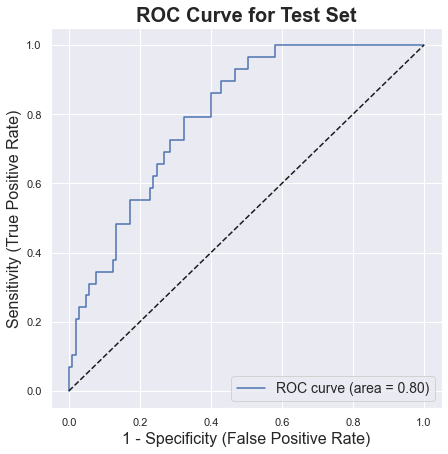

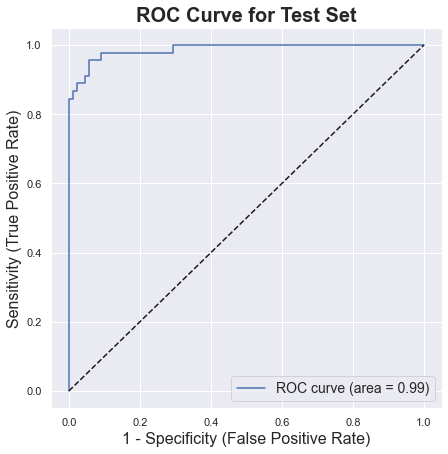

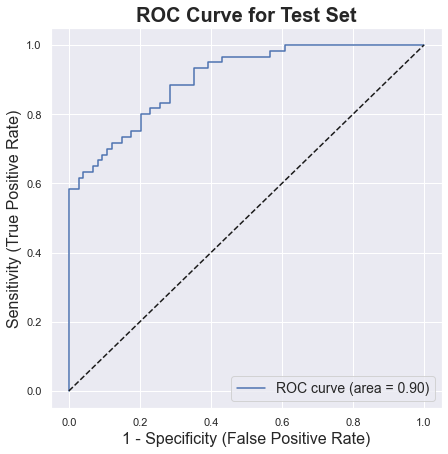

In [205]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged ROC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

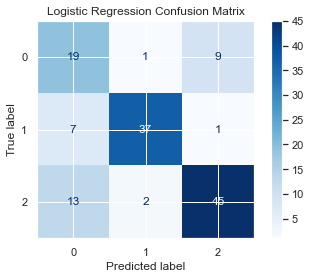

In [206]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

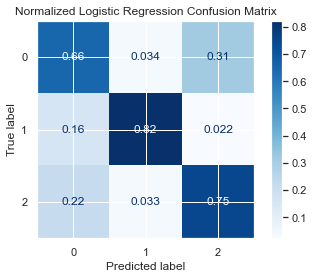

In [207]:
norm_matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [208]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [209]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.715 - 0.876]
95% Confidence interval for the AUC score for class 1: [0.969 - 0.998]
95% Confidence interval for the AUC score for class 2: [0.848 - 0.947]
95% Confidence interval for the Accuracy score for class 0: [0.687 - 0.828]
95% Confidence interval for the Accuracy score for class 1: [0.896 - 0.978]
95% Confidence interval for the Accuracy score for class 2: [0.739 - 0.866]
95% Confidence interval for the Specificity score for class 0: [0.739 - 0.892]
95% Confidence interval for the Specificity score for class 1: [0.964 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.800 - 0.949]
95% Confidence interval for the Precision score for class 0: [0.367 - 0.741]
95% Confidence interval for the Precision score for class 1: [0.729 - 0.943]
95% Confidence interval for the Precision score for class 2: [0.594 - 0.831]
95% Confidence interval for the Recall score for class 0: [0.289 - 0.625]
95% Confidence inte

Feature: 0, Score: -0.76671
Feature: 1, Score: 0.24235
Feature: 2, Score: -0.58922
Feature: 3, Score: 0.30354
Feature: 4, Score: -1.17101
Feature: 5, Score: 0.91817
Feature: 6, Score: -0.04035
Feature: 7, Score: -0.09421
Feature: 8, Score: -0.97824
Feature: 9, Score: 0.48199
Feature: 10, Score: 0.88817
Feature: 11, Score: 0.14405
Feature: 12, Score: 0.22916
Feature: 13, Score: -0.03565
Feature: 14, Score: 0.23421
Feature: 15, Score: -0.52546
Feature: 16, Score: -0.81981
Feature: 17, Score: -0.28636
Feature: 18, Score: -1.35464
Feature: 19, Score: -0.02770
Feature: 20, Score: -0.49505
Feature: 21, Score: 0.12939
Feature: 22, Score: 1.16426
Feature: 23, Score: -0.54865
Feature: 24, Score: 0.01491
Feature: 25, Score: 0.14039
Feature: 26, Score: 0.31350
Feature: 27, Score: 0.45284
Feature: 28, Score: -0.07959
Feature: 29, Score: -0.02135
Feature: 30, Score: -0.33136
Feature: 31, Score: -0.15568
Feature: 32, Score: 0.90273
Feature: 33, Score: -0.05866
Feature: 34, Score: 0.02442
Feature: 35

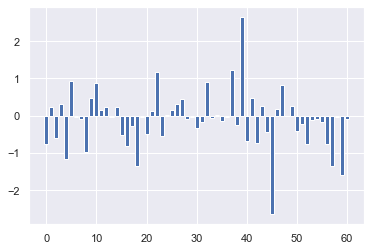

In [210]:
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

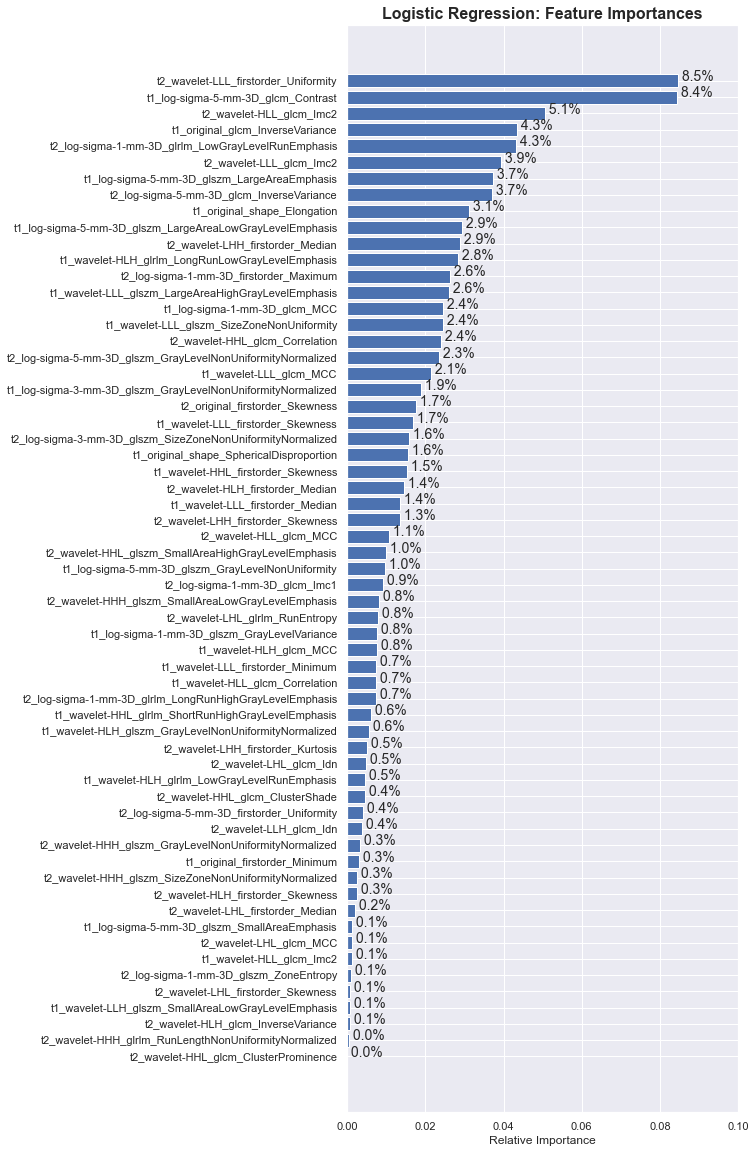

In [276]:
feature_names = X_test.columns.to_list()
importance = lr_model.coef_[0]
importance = np.abs(importance) / np.sum(np.abs(importance))
indices = np.argsort(importance)

plt.figure(figsize=(7, 20)) ##
plt.title('Logistic Regression: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.xlim(0, 0.10) ##
for index, value in enumerate(importance[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

# KNN

### Grid Search for Hyperparameters

In [211]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [212]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='accuracy')

In [213]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


### Model Performance

In [214]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [215]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.47      0.66      0.55        29
           1       0.88      0.64      0.74        45
           2       0.67      0.68      0.68        60

    accuracy                           0.66       134
   macro avg       0.68      0.66      0.66       134
weighted avg       0.70      0.66      0.67       134



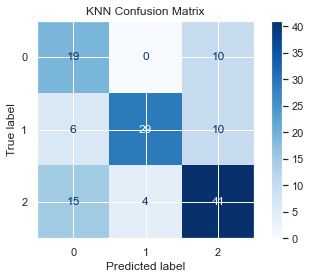

In [216]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

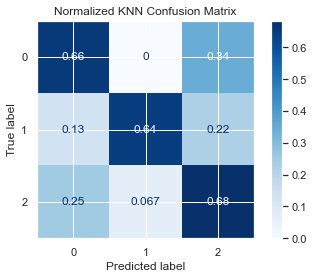

In [217]:
norm_matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized KNN Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.7686567164179104
pilo
Accuracy: 0.8507462686567164
mb
Accuracy: 0.7089552238805971
Micro-Averaged AUC: 0.8055246157273335


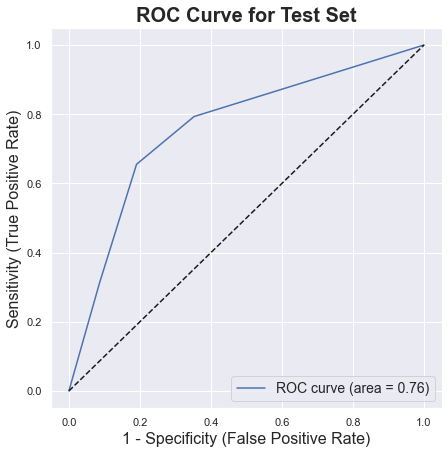

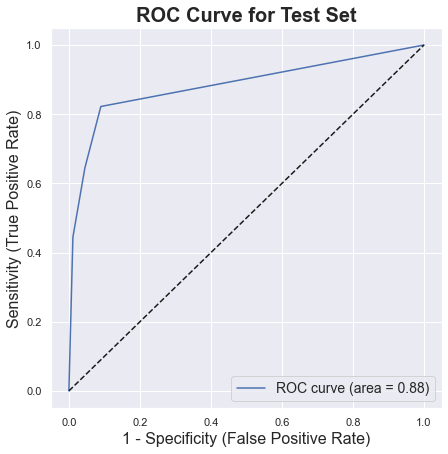

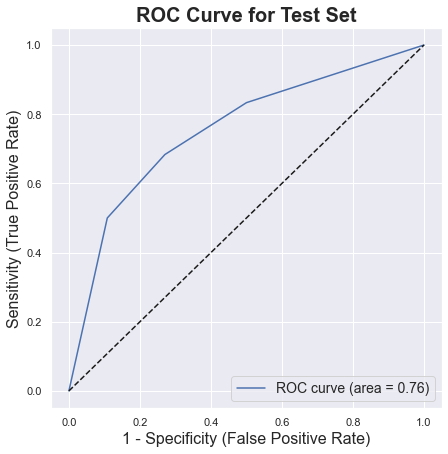

In [218]:
y_score = knn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [219]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [220]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.662 - 0.855]
95% Confidence interval for the AUC score for class 1: [0.814 - 0.941]
95% Confidence interval for the AUC score for class 2: [0.673 - 0.833]
95% Confidence interval for the Accuracy score for class 0: [0.701 - 0.836]
95% Confidence interval for the Accuracy score for class 1: [0.791 - 0.91]
95% Confidence interval for the Accuracy score for class 2: [0.627 - 0.784]
95% Confidence interval for the Specificity score for class 0: [0.721 - 0.875]
95% Confidence interval for the Specificity score for class 1: [0.908 - 0.99]
95% Confidence interval for the Specificity score for class 2: [0.625 - 0.833]
95% Confidence interval for the Precision score for class 0: [0.472 - 0.826]
95% Confidence interval for the Precision score for class 1: [0.500 - 0.78]
95% Confidence interval for the Precision score for class 2: [0.560 - 0.803]
95% Confidence interval for the Recall score for class 0: [0.317 - 0.629]
95% Confidence inter

# Random Forest

### Grid Search for Hyperparameters
 

In [221]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [222]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [223]:
print(rf_grid.best_params_)

{'max_depth': 4, 'n_estimators': 300}


### Model Performance

In [224]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 200, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [225]:
y_test_np = y_test.to_numpy()
TN = 0
TP = 0 ##
FN = 0 ##
FP = 0
tot_TN = TN
tot_FP = FP
spec_arr = []
ppv_arr = [] ##
npv_arr = [] ##

print("Specificities")
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TN += TN
    tot_FP += FP
    spec_arr.append(TN/(TN+FP))
    print(group, spec_arr[group])
    
print("Macro Avg : " + str(np.array(spec_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

print("PPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] == group and y_test_np[i] == group:
            TP += 1
        if y_pred[i] == group and y_test_np[i] != group:
            FP += 1
    tot_TP += TP
    tot_FP += FP
    ppv_arr.append(TP/(TP+FP))
    print(group, ppv_arr[group])
    
print("Macro Avg : " + str(np.array(ppv_arr).mean()))
print("Micro Avg : " + str(tot_TP / (tot_TP + tot_FP)), '\n')

print("NPV") ##
for group in range(3):
    for i in range(len(y_test_np)):
        if y_pred[i] != group and y_test_np[i] != group:
            TN += 1
        if y_pred[i] != group and y_test_np[i] == group:
            FN += 1
    tot_TN += TN
    tot_FN += FN
    npv_arr.append(TP/(TP+FP))
    print(group, npv_arr[group])
    
print("Macro Avg : " + str(np.array(npv_arr).mean()))
print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN))) 

Specificities
0 0.8952380952380953
1 0.9072164948453608
2 0.8656716417910447
Macro Avg : 0.8893754106248336
Micro Avg : 0.8853615520282186 

PPV
0 0.24193548387096775
1 0.49056603773584906
2 0.5764705882352941
Macro Avg : 0.4363240366140369
Micro Avg : 0.6788124156545209 

NPV
0 0.5764705882352941
1 0.5764705882352941
2 0.5764705882352941
Macro Avg : 0.5764705882352941
Micro Avg : 0.8909853249475891


In [226]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55        29
           1       0.84      0.82      0.83        45
           2       0.72      0.77      0.74        60

    accuracy                           0.73       134
   macro avg       0.71      0.70      0.71       134
weighted avg       0.73      0.73      0.73       134



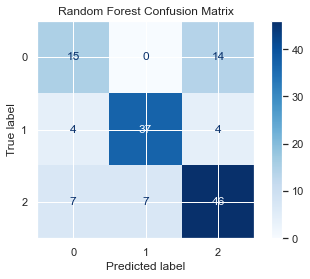

In [227]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

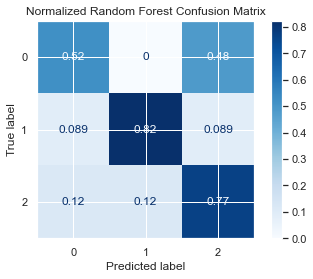

In [228]:
norm_matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.8134328358208955
pilo
Accuracy: 0.8880597014925373
mb
Accuracy: 0.7611940298507462
Micro-Averaged AUC: 0.9004789485408777


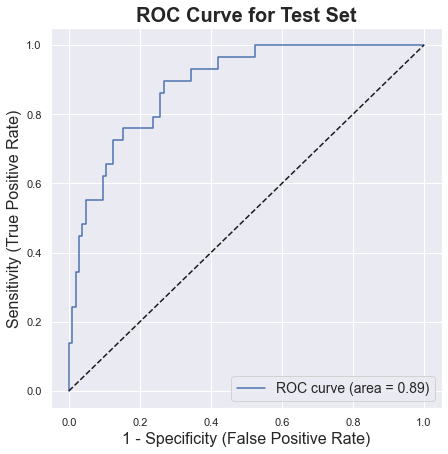

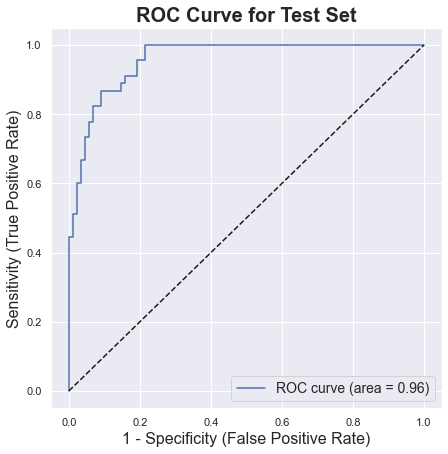

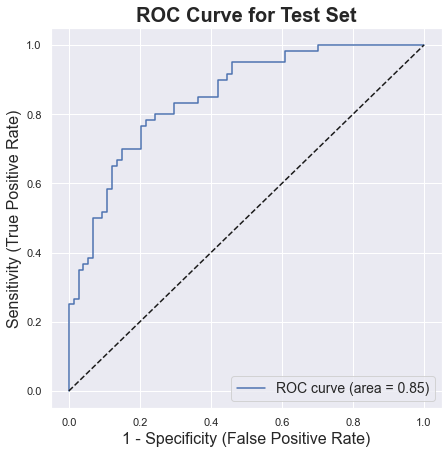

In [229]:
y_score = rf_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [230]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [231]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.820 - 0.941]
95% Confidence interval for the AUC score for class 1: [0.924 - 0.984]
95% Confidence interval for the AUC score for class 2: [0.784 - 0.91]
95% Confidence interval for the Accuracy score for class 0: [0.739 - 0.873]
95% Confidence interval for the Accuracy score for class 1: [0.828 - 0.94]
95% Confidence interval for the Accuracy score for class 2: [0.687 - 0.828]
95% Confidence interval for the Specificity score for class 0: [0.835 - 0.949]
95% Confidence interval for the Specificity score for class 1: [0.857 - 0.977]
95% Confidence interval for the Specificity score for class 2: [0.653 - 0.851]
95% Confidence interval for the Precision score for class 0: [0.333 - 0.704]
95% Confidence interval for the Precision score for class 1: [0.700 - 0.927]
95% Confidence interval for the Precision score for class 2: [0.661 - 0.875]
95% Confidence interval for the Recall score for class 0: [0.385 - 0.762]
95% Confidence inte

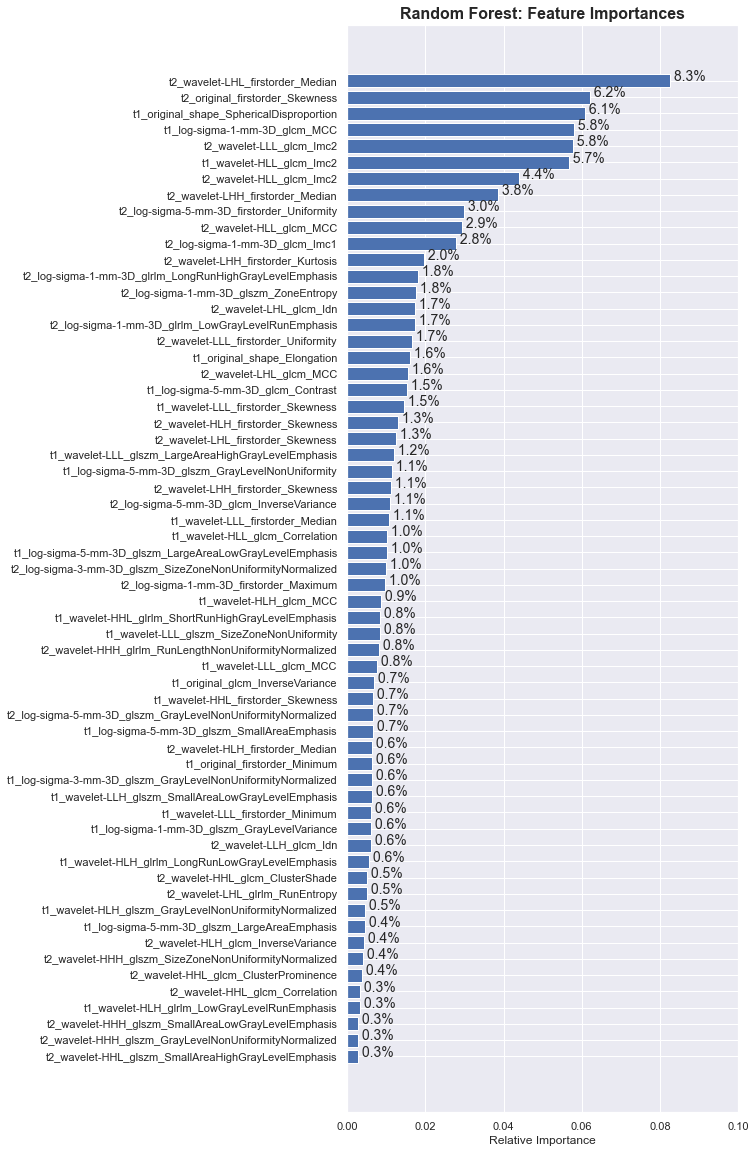

In [270]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 20)) ##
plt.title('Random Forest: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.10) ##
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost

### Grid Search for Hyperparameters

In [233]:
xgb_model = XGBClassifier(objective = 'multi:softmax', random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [234]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [235]:
print(xgb_grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 4}


### Model Performance

In [236]:
xgb_model = XGBClassifier(objective = 'multi:softmax', learning_rate = 0.3, max_depth = 4, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [237]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.45      0.50        29
           1       0.90      0.78      0.83        45
           2       0.69      0.83      0.76        60

    accuracy                           0.73       134
   macro avg       0.72      0.69      0.70       134
weighted avg       0.73      0.73      0.73       134



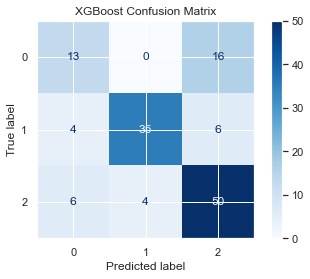

In [238]:
matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

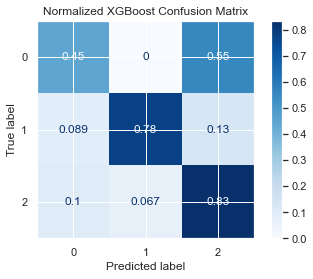

In [239]:
norm_matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.8059701492537313
pilo
Accuracy: 0.8955223880597015
mb
Accuracy: 0.7611940298507462
Micro-Averaged AUC: 0.9135108041880151


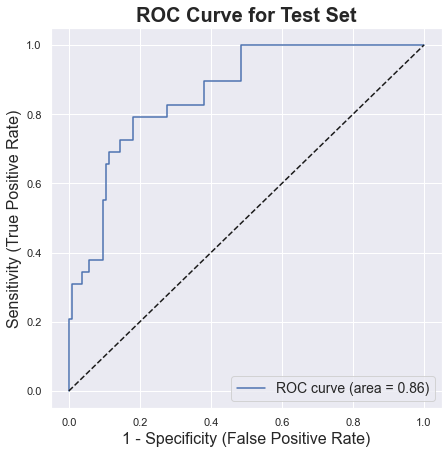

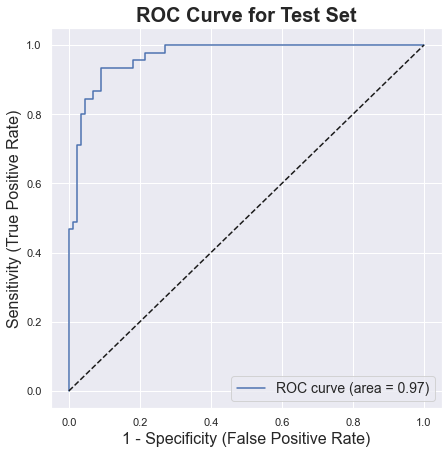

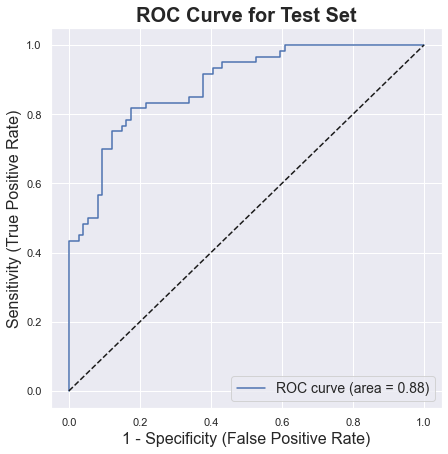

In [240]:
y_score = xgb_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [241]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [242]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.787 - 0.924]
95% Confidence interval for the AUC score for class 1: [0.938 - 0.989]
95% Confidence interval for the AUC score for class 2: [0.824 - 0.936]
95% Confidence interval for the Accuracy score for class 0: [0.731 - 0.873]
95% Confidence interval for the Accuracy score for class 1: [0.843 - 0.94]
95% Confidence interval for the Accuracy score for class 2: [0.687 - 0.828]
95% Confidence interval for the Specificity score for class 0: [0.845 - 0.958]
95% Confidence interval for the Specificity score for class 1: [0.905 - 0.989]
95% Confidence interval for the Specificity score for class 2: [0.595 - 0.806]
95% Confidence interval for the Precision score for class 0: [0.276 - 0.633]
95% Confidence interval for the Precision score for class 1: [0.651 - 0.891]
95% Confidence interval for the Precision score for class 2: [0.735 - 0.925]
95% Confidence interval for the Recall score for class 0: [0.357 - 0.765]
95% Confidence int

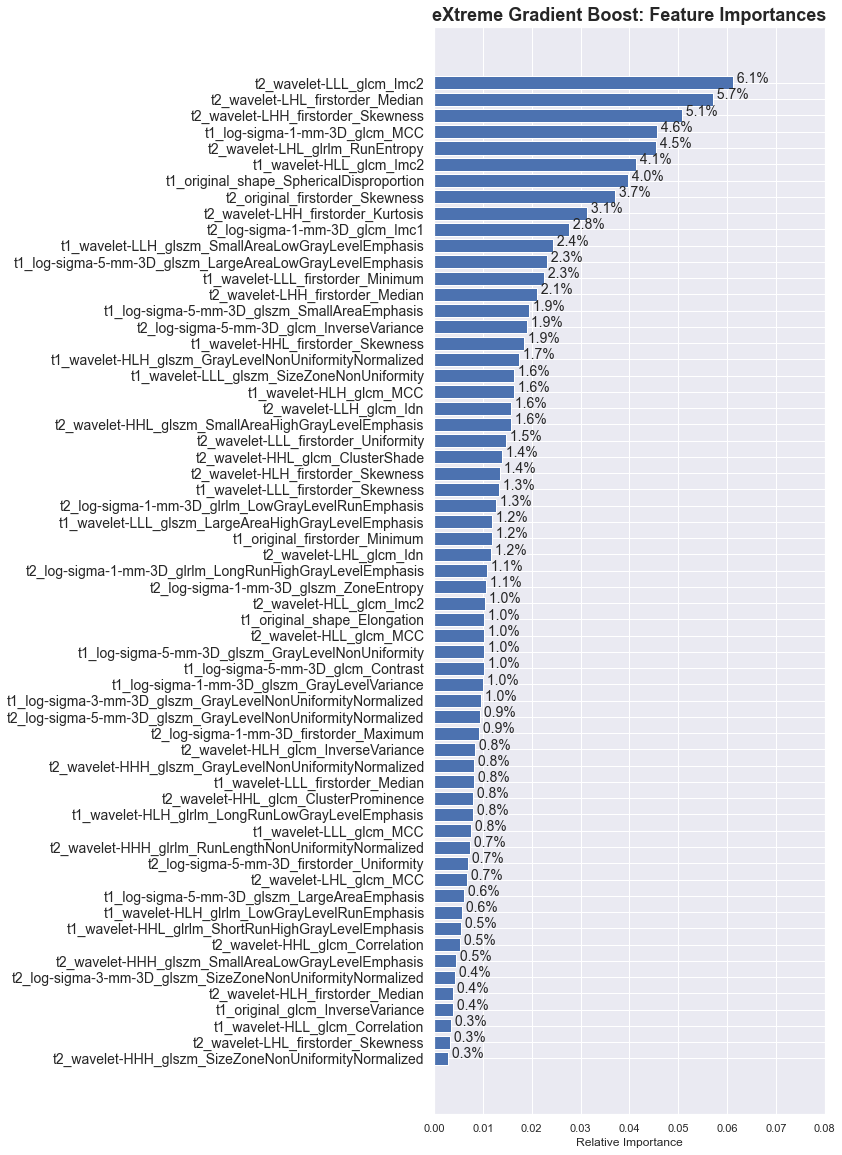

In [267]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 20)) ##
plt.title('eXtreme Gradient Boost: Feature Importances', fontsize=18, fontweight='semibold') ##
plt.xlim(0, 0.08) ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance')

plt.show()

# Neural Net

### Grid Search for Hyperparameters

In [244]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [245]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [246]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}


### Model Performance

In [247]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [248]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.58      0.62      0.60        29
           1       0.92      0.80      0.86        45
           2       0.83      0.88      0.85        60

    accuracy                           0.80       134
   macro avg       0.78      0.77      0.77       134
weighted avg       0.81      0.80      0.80       134



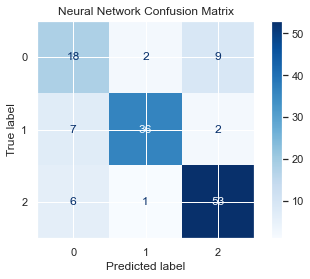

In [249]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

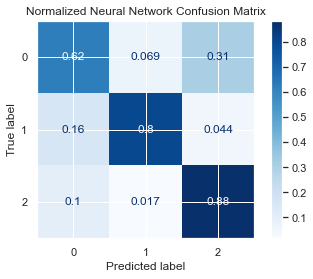

In [250]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

ep
Accuracy: 0.8208955223880597
pilo
Accuracy: 0.9104477611940298
mb
Accuracy: 0.8656716417910447
Micro-Averaged AUC: 0.9308309200267321


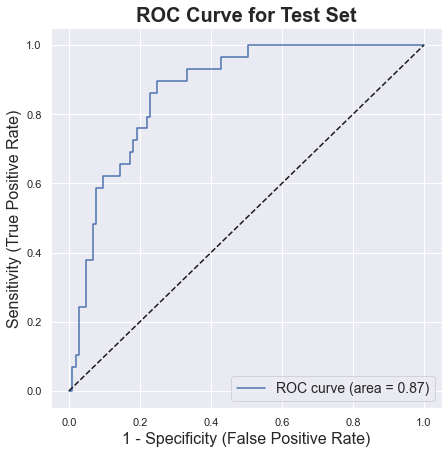

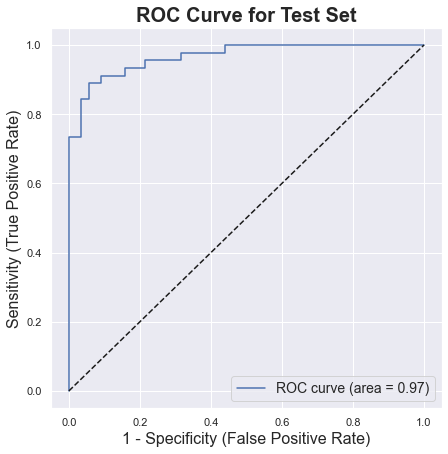

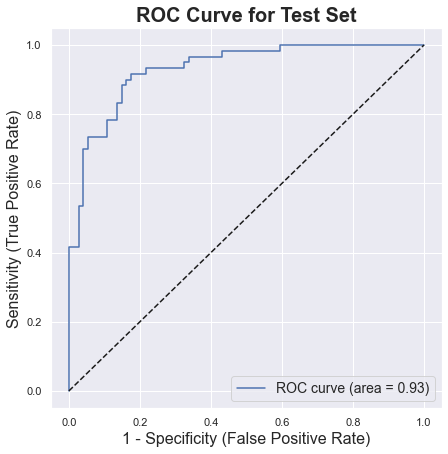

In [251]:
y_score = nn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [252]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [253]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the AUC score for class 0: [0.804 - 0.929]
95% Confidence interval for the AUC score for class 1: [0.936 - 0.99]
95% Confidence interval for the AUC score for class 2: [0.886 - 0.969]
95% Confidence interval for the Accuracy score for class 0: [0.754 - 0.888]
95% Confidence interval for the Accuracy score for class 1: [0.858 - 0.955]
95% Confidence interval for the Accuracy score for class 2: [0.806 - 0.918]
95% Confidence interval for the Specificity score for class 0: [0.807 - 0.936]
95% Confidence interval for the Specificity score for class 1: [0.924 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.764 - 0.931]
95% Confidence interval for the Precision score for class 0: [0.435 - 0.808]
95% Confidence interval for the Precision score for class 1: [0.674 - 0.911]
95% Confidence interval for the Precision score for class 2: [0.796 - 0.958]
95% Confidence interval for the Recall score for class 0: [0.400 - 0.759]
95% Confidence inter